# Customer Segmentation
### Machine Learning II Project
- Bruno Moreira
- Carolina Braziel Shaul 
- Madalena Frango

#### 1. Importing Data & Libraries

In [54]:
#Basic Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

#To find addresses
import reverse_geocoder as rg
from geopy.geocoders import Nominatim

#Plot Maps
import folium
from folium.plugins import HeatMap, MarkerCluster 

#Functions
import Functions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
customers = pd.read_csv('Customer Info Dataset.csv')
transactions = pd.read_csv('Customer Basket Dataset.csv')
prod_mapping = pd.read_excel('Product Mapping Excel File.xlsx')

## Customers Dataset Analysis

#### 2. Preprocessing: Data Cleaning, Feature Extraction and Feature Selection.

**Verifying duplicates**

In [5]:
customers[customers['customer_id'].duplicated() == True]

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude


In [6]:
customers.set_index('customer_id', inplace=True)

In [7]:
customers[customers.duplicated() == True]

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,


 **Summary Statistics**

In [8]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
kids_home,30000.0,1.146700e+00,1.234111,0.000000e+00,0.000000,1.000000,1.000000,10.000000
teens_home,30000.0,5.129333e-01,0.912502,0.000000e+00,0.000000,0.000000,1.000000,9.000000
number_complaints,30000.0,7.643667e-01,0.836341,0.000000e+00,0.000000,1.000000,1.000000,9.000000
distinct_stores_visited,30000.0,6.120767e+00,6.511410,0.000000e+00,2.000000,3.000000,8.000000,21.000000
lifetime_spend_groceries,30000.0,3.978634e+03,5280.641466,0.000000e+00,220.000000,950.000000,5253.000000,18852.000000
lifetime_spend_electronics,30000.0,9.652388e+02,1755.323397,1.058527e+00,45.000000,194.000000,721.000000,6603.000000
typical_hour,30000.0,-inf,NaN,-inf,9.000000,14.000000,20.000000,23.000000
lifetime_spend_vegetables,30000.0,5.642078e+02,481.819086,1.000000e+00,247.000000,425.000000,785.000000,1568.000000
lifetime_spend_nonalcohol_drinks,30000.0,6.287501e+02,496.346400,0.000000e+00,244.000000,425.000000,949.000000,1671.000000
lifetime_spend_alcohol_drinks,30000.0,3.793445e+02,236.206400,0.000000e+00,193.000000,419.000000,537.000000,1048.000000


> Some weird patterns can be detected above: both variables *typical_hour* and *lifetime_spend_videogames* possess infinite values, which given their context, conditions their interpretation. Below, a more in-depth analysis of these features is done.

In [9]:
customers[customers['lifetime_spend_videogames'] == -np.inf]

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
1441,Fausto`s Supermarket,male,01/23/1989 11:26 AM,0.0,0.0,0.0,1.0,2.678482,1.095507,0.575646,...,2.613335,34425.0,1.556140,-inf,0.978006,0.199261,2008.0,961221.0,38.866242,-9.110871
3399,Sandy`s Supermarket,female,07/11/1970 12:57 PM,0.0,0.0,0.0,1.0,2.797932,1.141087,0.447940,...,2.623429,36152.0,1.555148,-inf,0.997246,0.201933,2009.0,NaN,38.866366,-9.111207
8086,Eugene`s Supermarket,male,02/29/1956 08:26 PM,0.0,0.0,0.0,1.0,2.802438,1.146242,0.173287,...,2.612483,34777.0,1.530623,-inf,0.951666,0.210895,2010.0,NaN,38.865887,-9.111353
9706,Michele`s Supermarket,female,12/06/1962 02:12 AM,0.0,0.0,0.0,1.0,2.844843,1.184050,0.708303,...,2.615854,35000.0,1.555148,-inf,0.997246,0.200211,2009.0,NaN,38.866273,-9.111174
17805,Robert`s Supermarket,male,09/22/1982 03:36 AM,0.0,0.0,0.0,1.0,2.751432,1.127715,0.599474,...,2.619223,35809.0,1.553152,-inf,1.006338,0.195712,2008.0,NaN,38.866607,-9.111206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,Justin`s Supermarket,male,03/20/1959 03:59 PM,0.0,0.0,0.0,1.0,2.741558,1.113587,0.621227,...,2.613508,34834.0,1.552650,-inf,0.967800,0.203212,2011.0,NaN,38.866031,-9.111438
16270,Melissa`s Supermarket,female,05/11/1996 05:49 AM,0.0,0.0,0.0,1.0,2.768803,1.175120,0.519860,...,2.619885,34631.0,1.571034,-inf,0.987811,0.198526,2008.0,NaN,38.865962,-9.110773
10262,Francis`s Supermarket,male,11/05/1970 01:58 AM,0.0,0.0,0.0,1.0,2.788190,1.130447,0.693147,...,2.621949,34708.0,1.553152,-inf,0.957160,0.191255,2010.0,NaN,38.866438,-9.111502


In [10]:
customers[customers['typical_hour'] == -np.inf]

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
8592,Charles`s Supermarket,male,01/18/1988 04:13 AM,0.0,0.0,0.0,1.0,2.64414,1.130447,-inf,...,2.615969,35005.0,1.540302,-inf,0.95716,0.196409,2013.0,NaN,38.866685,-9.111366
101,Annie`s Supermarket,female,11/23/1947 10:33 AM,0.0,0.0,0.0,1.0,2.65918,1.133150,-inf,...,2.608573,34702.0,1.553652,-inf,0.91589,0.194451,2009.0,910065.0,38.866048,-9.111718


> It seems that this particularity solely applies to customers who have present in their name "Supermarket". For this reason, we will perform a separate analysis to this group, and correct these values. For the variable *lifetime_spend_videogames*, the infinite values will be interpreted as "non-applicable" and thus, will be equal to 0. In the case of *typical_hour*, the mean value of the other observations within this group will be imputed.

In [11]:
customers['lifetime_spend_videogames'] = np.where(customers['lifetime_spend_videogames'] == -np.inf, 0, customers['lifetime_spend_videogames'])

In [12]:
imputed_value = customers[(customers['customer_name'].str.contains('Supermarket')) & (customers['typical_hour'] != -np.inf)]['typical_hour'].mean()

In [13]:
customers['typical_hour'] = np.where(customers['typical_hour'] == -np.inf, imputed_value, customers['typical_hour'])

In [14]:
(customers[customers['customer_name'].str.contains('Supermarket')]).describe().T

,count,mean,std,min,25%,50%,75%,max
kids_home,226.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
teens_home,226.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
number_complaints,226.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
distinct_stores_visited,226.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lifetime_spend_groceries,226.0,2.701444,0.057132,2.423006,2.669260,2.707140,2.741420,2.844843
lifetime_spend_electronics,226.0,1.149498,0.026245,1.058527,1.130447,1.151293,1.165860,1.222587
typical_hour,226.0,0.625775,0.154783,0.000000,0.575646,0.693147,0.722593,0.783874
lifetime_spend_vegetables,226.0,2.124160,0.026242,2.042546,2.105281,2.126912,2.143535,2.183680
lifetime_spend_nonalcohol_drinks,226.0,2.302082,0.012521,2.266444,2.293678,2.303334,2.309999,2.334485
lifetime_spend_alcohol_drinks,226.0,2.704784,0.002484,2.697901,2.703110,2.704669,2.706443,2.712882


> As it is possible to perceive, the Supermarket Group has a very distinct behaviour: the standard deviation for many variables either is or tends to 0, meaning that this is quite a homogeneous selection of observations.

 **Correcting Missing Values and Features dtypes**

In [15]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 4239 to 2570
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_name                            30000 non-null  object 
 1   customer_gender                          30000 non-null  object 
 2   customer_birthdate                       30000 non-null  object 
 3   kids_home                                30000 non-null  float64
 4   teens_home                               30000 non-null  float64
 5   number_complaints                        30000 non-null  float64
 6   distinct_stores_visited                  30000 non-null  float64
 7   lifetime_spend_groceries                 30000 non-null  float64
 8   lifetime_spend_electronics               30000 non-null  float64
 9   typical_hour                             30000 non-null  float64
 10  lifetime_spend_vegetables                300

> There exist missing values solely in the feature *loyalty_card_number*, which can translate as "non-applicable" (the individual has no loyalty card associated to them). In these cases, imputation should not be considered - and due to the percentage of observations within this condition and the meaning of this feature, it does not present great value. For this reason, it will be further used to create a binary variable indicating whether the customer has a loyalty card or not. 

In [16]:
customers['customer_birthdate'] = pd.to_datetime(customers['customer_birthdate'])
Functions.integer_convert(customers, ['number_complaints', 'kids_home', 'teens_home', 'distinct_stores_visited', 'lifetime_total_distinct_products', 'year_first_transaction'])

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,female,1999-09-10 15:11:00,0,0,0,2,91.0,20.0,22.0,...,53.0,48.0,47.0,105.0,85,0.192154,2017,NaN,38.754263,-9.163397
19330,Donald Robertson,male,1981-06-26 22:58:00,1,0,0,2,197.0,5958.0,21.0,...,86.0,80.0,45.0,1964.0,85,0.098647,2015,NaN,38.777761,-9.156197
2272,Phd. Felicia Bradshaw,female,1987-01-31 09:08:00,1,1,0,20,397.0,20.0,9.0,...,204.0,170.0,46.0,5.0,408,0.497251,2008,NaN,38.785329,-9.127113
25288,Emma Williams,female,1942-06-17 00:02:00,3,4,1,2,5282.0,237.0,12.0,...,1081.0,1068.0,617.0,1078.0,1956,0.206713,2010,NaN,38.744086,-9.156589
12829,Hilda Huerta,female,2000-01-31 11:43:00,0,0,0,2,82.0,22.0,21.0,...,39.0,39.0,48.0,103.0,83,0.200625,2015,NaN,38.756024,-9.162970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Phd. Karen Watts,female,1974-11-01 05:26:00,0,0,1,2,209.0,5474.0,20.0,...,21.0,11.0,57.0,1984.0,112,0.096366,2008,935162.0,38.734446,-9.171911
26447,Curtis Thompson,male,1986-02-21 11:27:00,0,0,0,3,185.0,1066.0,15.0,...,47.0,41.0,50.0,197.0,22,0.118998,2014,NaN,38.767070,-9.144301
182,Richard Carter,male,2001-01-14 05:49:00,0,0,0,2,83.0,23.0,23.0,...,55.0,52.0,51.0,94.0,77,0.199432,2016,953891.0,38.728487,-9.164140


**Feature Extraction**

Several features will be created. Some solely for the individual customers (non-supermarket), while others for all observations. Their descriptions follow:

_For individual clients_:

- **minors_household**: Number of minors present in the household.
- **education**: Individual's Education Level.
- **birthday**: Individual's day of birth.
- **birthmonth**: Individual's month of birth.
- **birthyear**: Individual's year of birth.

_For supermarkets_:

_For all customers_:
- **total_lifetime_spent**: Total lifetime amount spent.
- **loyalty_card**: Whether the customer has a loyalty card or not.
- **latitude_encoded**: Latitude of the municipality of residence of the customer.
- **longitude_encoded**: Longitude of the municipality of residence of the customer.

_Creating the features for all customers_

In [17]:
#Loyalty Card
Functions.binary_encoding(df = customers, col_name = 'loyalty_card', 
                          condition = (np.isnan(customers['loyalty_card_number']) == True))


customers['total_lifetime_spend'] = customers[['lifetime_spend_groceries',
       'lifetime_spend_electronics','lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames']].sum(axis=1)


#customers['address'] = customers.apply(lambda row: Functions.get_address(row), axis=1)

**IGNORAR PASSOS INTERMÉDIOS**

In [18]:
# customers.to_csv('customers_location.csv', index=True)

In [19]:
customers2 = pd.read_csv('customers_location.csv')

In [20]:
customers2.set_index('customer_id', inplace=True)

In [21]:
customers = pd.concat([customers, customers2['address']], axis=1)

**DEIXAR DE IGNORAR**

In [22]:
customers['address2'] = customers['address'].apply(lambda row: Functions.clean_address_bruno(row))
Functions.encode_address(customers, 'latitude', 'longitude', 'address2')

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,year_first_transaction,loyalty_card_number,latitude,longitude,loyalty_card,total_lifetime_spend,address,address2,latitude_encoded,longitude_encoded
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,female,1999-09-10 15:11:00,0,0,0,2,91.0,20.0,22.0,...,2017,NaN,38.754263,-9.163397,0,1545.0,"Estádio Universitário de Lisboa, Azinhaga das ...",Alvalade,38.753506,-9.150181
19330,Donald Robertson,male,1981-06-26 22:58:00,1,0,0,2,197.0,5958.0,21.0,...,2015,NaN,38.777761,-9.156197,0,10219.0,"Avenida David Mourão-Ferreira, Bairro da Cruz ...",Lumiar,38.768765,-9.163855
2272,Phd. Felicia Bradshaw,female,1987-01-31 09:08:00,1,1,0,20,397.0,20.0,9.0,...,2008,NaN,38.785329,-9.127113,0,1753.0,"Rua Engenheiro Adão Manuel Ramos Barata, Sacav...",Loures,38.821100,-9.115927
25288,Emma Williams,female,1942-06-17 00:02:00,3,4,1,2,5282.0,237.0,12.0,...,2010,NaN,38.744086,-9.156589,0,11195.0,"Rua Veloso Salgado, Bairro do Rego, Campo Pequ...",Avenidas Novas,38.737745,-9.152875
12829,Hilda Huerta,female,2000-01-31 11:43:00,0,0,0,2,82.0,22.0,21.0,...,2015,NaN,38.756024,-9.162970,0,1370.0,"Estádio Universitário de Lisboa, Azinhaga das ...",Alvalade,38.753506,-9.150181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Phd. Karen Watts,female,1974-11-01 05:26:00,0,0,1,2,209.0,5474.0,20.0,...,2008,935162.0,38.734446,-9.171911,1,9730.0,"37ª Esquadra - Serafina, 25, Rua Miguel Ângelo...",Campolide,38.731513,-9.166444
26447,Curtis Thompson,male,1986-02-21 11:27:00,0,0,0,3,185.0,1066.0,15.0,...,2014,NaN,38.767070,-9.144301,0,2416.0,"Terminal de Carga Aérea, Avenida Eugénio de An...",Olivais,38.772268,-9.128820
182,Richard Carter,male,2001-01-14 05:49:00,0,0,0,2,83.0,23.0,23.0,...,2016,953891.0,38.728487,-9.164140,1,1491.0,"OPTIMISTIC, Rua Campos Júnior, Bairro de Campo...",Campolide,38.731513,-9.166444


In [23]:
customers['address2'].unique()

array(['Alvalade', 'Lumiar', 'Loures', 'Avenidas Novas', 'Santo António',
       'Carnide', 'Penha de França', 'Olivais', 'São Domingos de Benfica',
       'Arroios', 'Benfica', 'Estrela', 'Marvila', 'Campolide',
       'Santa Clara', 'Ajuda', 'Misericórdia', 'São Vicente', 'Setúbal',
       'Campo de Ourique', 'Parque das Nações', 'Alcântara', 'Amadora',
       'Odivelas', 'Beato', 'Areeiro', 'Santa Maria Maior', 'Oeiras',
       'Belém', 'Almada'], dtype=object)

> To create the features for individuals only, we will separate the original dataset into two separate dataframes, one for each group.

In [24]:
supermarkets = customers[customers['customer_name'].str.contains('Supermarket')]

In [25]:
individuals = customers[~customers.isin(supermarkets)].dropna(how='all')

_Creating the features for individual customers and encoding data_

In [26]:
#Minors In Household
individuals['minors_in_household'] = (individuals[['kids_home', 'teens_home']]).sum(axis=1)

#Birthday, Birthmonth and Birthyear
Functions.process_birthdate(individuals, 'customer_birthdate')

#Education Level
individuals['education'] = individuals['customer_name'].apply(lambda row : Functions.extract_education(row))

#Encoding Gender Feature
Functions.binary_encoding(individuals, 'customer_gender', condition=(individuals['customer_gender'] == 'male'))

#Cleansing the customer's name
individuals['customer_name'] = individuals['customer_name'].apply(lambda row: Functions.clean_names(row))

In [27]:
individuals

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,total_lifetime_spend,address,address2,latitude_encoded,longitude_encoded,minors_in_household,birthday,birthmonth,age,education
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1,1999-09-10 15:11:00,0.0,0.0,0.0,2.0,91.0,20.0,22.0,...,1545.0,"Estádio Universitário de Lisboa, Azinhaga das ...",Alvalade,38.753506,-9.150181,0.0,10,9,24,0
19330,Donald Robertson,0,1981-06-26 22:58:00,1.0,0.0,0.0,2.0,197.0,5958.0,21.0,...,10219.0,"Avenida David Mourão-Ferreira, Bairro da Cruz ...",Lumiar,38.768765,-9.163855,1.0,26,6,42,0
2272,Felicia Bradshaw,1,1987-01-31 09:08:00,1.0,1.0,0.0,20.0,397.0,20.0,9.0,...,1753.0,"Rua Engenheiro Adão Manuel Ramos Barata, Sacav...",Loures,38.821100,-9.115927,2.0,31,1,36,3
25288,Emma Williams,1,1942-06-17 00:02:00,3.0,4.0,1.0,2.0,5282.0,237.0,12.0,...,11195.0,"Rua Veloso Salgado, Bairro do Rego, Campo Pequ...",Avenidas Novas,38.737745,-9.152875,7.0,17,6,81,0
12829,Hilda Huerta,1,2000-01-31 11:43:00,0.0,0.0,0.0,2.0,82.0,22.0,21.0,...,1370.0,"Estádio Universitário de Lisboa, Azinhaga das ...",Alvalade,38.753506,-9.150181,0.0,31,1,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Karen Watts,1,1974-11-01 05:26:00,0.0,0.0,1.0,2.0,209.0,5474.0,20.0,...,9730.0,"37ª Esquadra - Serafina, 25, Rua Miguel Ângelo...",Campolide,38.731513,-9.166444,0.0,1,11,49,3
26447,Curtis Thompson,0,1986-02-21 11:27:00,0.0,0.0,0.0,3.0,185.0,1066.0,15.0,...,2416.0,"Terminal de Carga Aérea, Avenida Eugénio de An...",Olivais,38.772268,-9.128820,0.0,21,2,37,0
182,Richard Carter,0,2001-01-14 05:49:00,0.0,0.0,0.0,2.0,83.0,23.0,23.0,...,1491.0,"OPTIMISTIC, Rua Campos Júnior, Bairro de Campo...",Campolide,38.731513,-9.166444,0.0,14,1,22,0


**Initial Feature Selection**

In [28]:
individuals.drop(['customer_birthdate', 'loyalty_card_number', 'latitude', 'longitude', 'address'], axis=1, inplace=True)
supermarkets.drop(['customer_name','percentage_of_products_bought_promotion', 
                   'year_first_transaction', 'loyalty_card', 'address2', 
                   'latitude_encoded', 'longitude_encoded'], axis=1, inplace=True)

C:\Users\carolinashaul\AppData\Local\Temp\ipykernel_14804\2515542260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supermarkets.drop(['customer_name','percentage_of_products_bought_promotion',


**Final Conversion of dtypes**

In [29]:
Functions.integer_convert(individuals, ['number_complaints', 'kids_home', 'teens_home', 'distinct_stores_visited', 'lifetime_total_distinct_products', 'year_first_transaction', 'typical_hour', 'loyalty_card', 'minors_in_household' ])

,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,...,loyalty_card,total_lifetime_spend,address2,latitude_encoded,longitude_encoded,minors_in_household,birthday,birthmonth,age,education
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1,0,0,0,2,91.0,20.0,22,22.0,...,0,1545.0,Alvalade,38.753506,-9.150181,0,10,9,24,0
19330,Donald Robertson,0,1,0,0,2,197.0,5958.0,21,20.0,...,0,10219.0,Lumiar,38.768765,-9.163855,1,26,6,42,0
2272,Felicia Bradshaw,1,1,1,0,20,397.0,20.0,9,310.0,...,0,1753.0,Loures,38.821100,-9.115927,2,31,1,36,3
25288,Emma Williams,1,3,4,1,2,5282.0,237.0,12,499.0,...,0,11195.0,Avenidas Novas,38.737745,-9.152875,7,17,6,81,0
12829,Hilda Huerta,1,0,0,0,2,82.0,22.0,21,9.0,...,0,1370.0,Alvalade,38.753506,-9.150181,0,31,1,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Karen Watts,1,0,0,1,2,209.0,5474.0,20,18.0,...,1,9730.0,Campolide,38.731513,-9.166444,0,1,11,49,3
26447,Curtis Thompson,0,0,0,0,3,185.0,1066.0,15,267.0,...,0,2416.0,Olivais,38.772268,-9.128820,0,21,2,37,0
182,Richard Carter,0,0,0,0,2,83.0,23.0,23,23.0,...,1,1491.0,Campolide,38.731513,-9.166444,0,14,1,22,0


In [30]:
# individuals.to_csv('clientes_preprocessed.csv', index=True)

#### 3. Univariate Analysis and Features' Distributions

#### Individuals

[Text(0.5, 1.0, 'Age')]

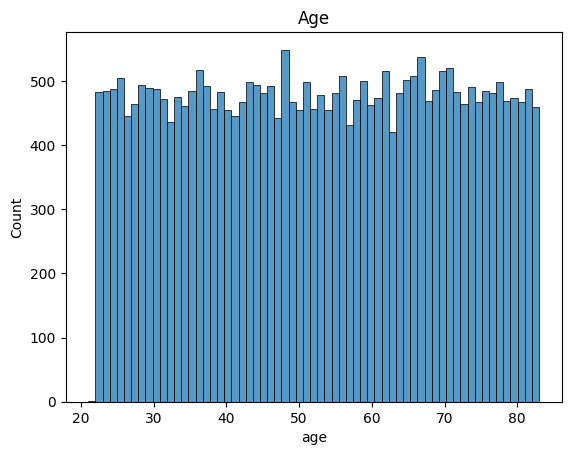

In [31]:
sns.histplot(individuals["age"], stat = 'count', bins= individuals['age'].nunique()).set(title="Age")

In [32]:
# def bar_charts(df, var):
#     sns.countplot(data=df, x=var)
#     plt.show()

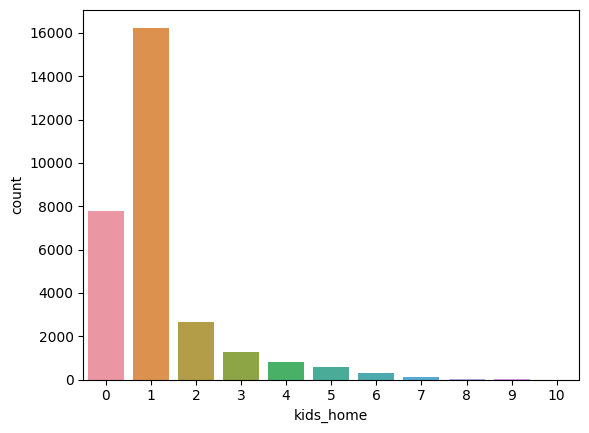

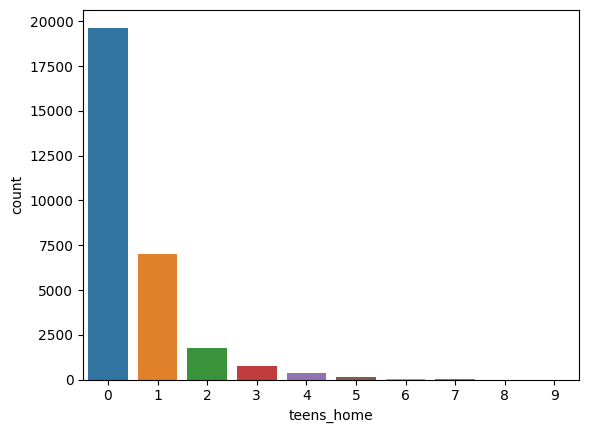

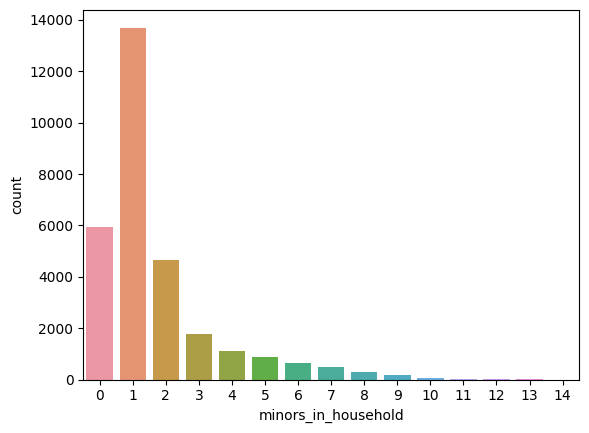

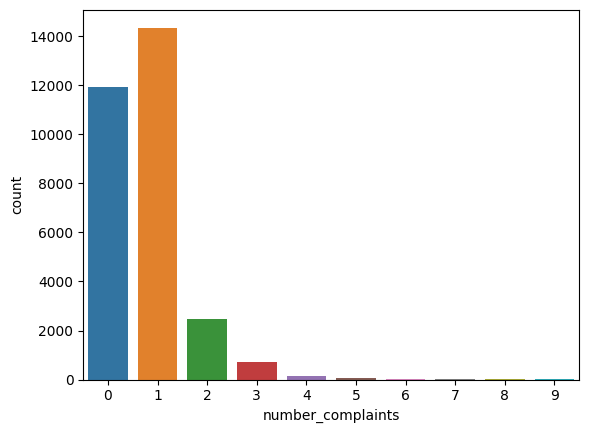

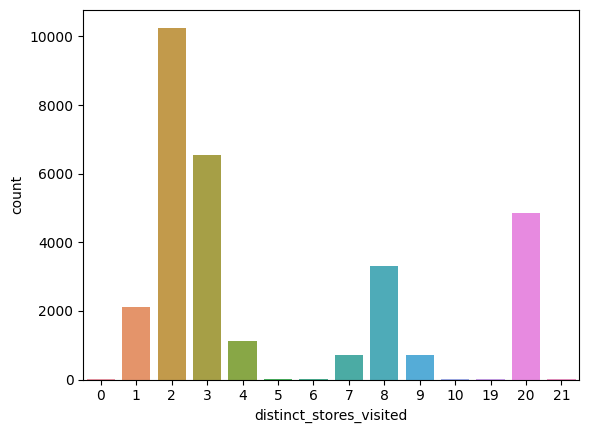

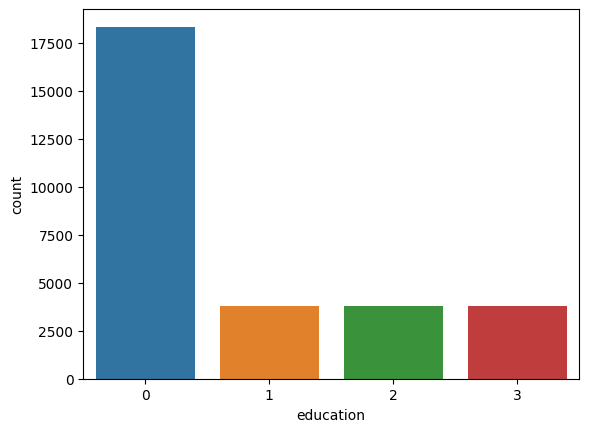

In [33]:
for column in ['kids_home', 'teens_home', 'minors_in_household', 'number_complaints', 'distinct_stores_visited', 'education']:
    Functions.bar_charts(individuals, column)

In [ ]:
sns.histplot(individuals["lifetime_spend_groceries"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["year_first_transaction"], stat = 'count', bins= 'auto').set(title="year_first_transaction")

In [ ]:
sns.scatterplot(data=individuals, x="year_first_transaction", y="lifetime_spend_electronics")

In [ ]:
sns.histplot(individuals["lifetime_spend_electronics"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_electronics")

In [ ]:
sns.histplot(individuals["lifetime_spend_vegetables"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_vegetables")

In [ ]:
sns.histplot(individuals["lifetime_spend_nonalcohol_drinks"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_nonalcohol_drinks")

In [ ]:
sns.histplot(individuals["lifetime_spend_alcohol_drinks"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["lifetime_spend_meat"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["lifetime_spend_fish"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["lifetime_spend_hygiene"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["lifetime_spend_videogames"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.scatterplot(data=individuals, x='lifetime_spend_electronics', y='lifetime_spend_videogames')

In [ ]:
sns.histplot(individuals["lifetime_total_distinct_products"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.histplot(individuals["percentage_of_products_bought_promotion"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
sns.countplot(data=individuals, x="year_first_transaction")

In [ ]:
individuals['loyalty_card'].value_counts()

In [ ]:
sns.histplot(individuals["total_lifetime_spend"], stat = 'count', bins= 'auto').set(title="Lifetime_spend_groceries")

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,6), sharey=True)
sns.histplot(individuals["lifetime_spend_groceries"], stat = 'count', bins= 'auto', ax = axes[0,0])
sns.histplot(individuals["lifetime_spend_electronics"], stat = 'count', bins= 'auto', ax = axes[0,1])
sns.histplot(individuals["lifetime_spend_vegetables"], stat = 'count', bins= 'auto', ax = axes[0,2])
sns.histplot(individuals["lifetime_spend_nonalcohol_drinks"], stat = 'count', bins= 'auto', ax = axes[1,0])
sns.histplot(individuals["lifetime_spend_alcohol_drinks"], stat = 'count', bins= 'auto', ax = axes[1,1])
sns.histplot(individuals["lifetime_spend_meat"], stat = 'count', bins= 'auto', ax = axes[1,2])
sns.histplot(individuals["lifetime_spend_fish"], stat = 'count', bins= 'auto', ax = axes[2,0])
sns.histplot(individuals["lifetime_spend_hygiene"], stat = 'count', bins= 'auto', ax = axes[2,1])
sns.histplot(individuals["lifetime_spend_videogames"], stat = 'count', bins= 'auto', ax = axes[2,2])

In [ ]:
individuals[['customer_gender','lifetime_spend_hygiene']].boxplot(by='customer_gender')
plt.show()

In [ ]:
individuals['education'].value_counts()

In [ ]:
individuals['customer_gender'].value_counts()

In [ ]:
individuals.groupby('customer_gender')[['lifetime_spend_vegetables', 'lifetime_spend_groceries', 
                                        'lifetime_spend_electronics', 
                                        'lifetime_spend_nonalcohol_drinks', 
                                        'lifetime_spend_alcohol_drinks', 
                                        'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
                                        'lifetime_spend_videogames', 'lifetime_total_distinct_products',
                                        'percentage_of_products_bought_promotion']].mean().T

In [ ]:
individuals.groupby('address2')[['total_lifetime_spend', 'lifetime_total_distinct_products',
                                        'percentage_of_products_bought_promotion']].aggregate(['mean', 'count'])

In [ ]:
individuals.groupby('education')[['total_lifetime_spend', 'lifetime_total_distinct_products',
                                        'percentage_of_products_bought_promotion']].aggregate(['mean', 'count', 'std']).T

Aqui parece que encontramos algo interessante, clientes com a educação básica aparentam gastar menos em média que pessoas com outros níveis de educação, e em média também comprar uma percentagem maior de produtos em promoção, apesar de ter uma std mais elevadas em ambos esses campos.

In [ ]:
individuals.groupby(['minors_in_household'])[['total_lifetime_spend', 'lifetime_total_distinct_products',
                                        'percentage_of_products_bought_promotion']].aggregate(['mean', 'count', 'std'])


In [ ]:
individuals[['total_lifetime_spend','minors_in_household']].boxplot(by='minors_in_household')
plt.show()


In [ ]:
individuals.groupby(['address2'])['minors_in_household'].median().sort_values()


In [ ]:
individuals[(individuals['address2'] == 'Amadora') & (individuals['minors_in_household'] > 6)]

> **distribuição de observações por localização** (Mapa)

In [ ]:
map_lisbon = folium.Map(location=[38.7223, -9.1393], zoom_start=12)
marker_cluster = MarkerCluster().add_to(map_lisbon)
for index, row in customers.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)

# Display the map
map_lisbon

In [ ]:
map_lisbon = folium.Map(location=[38.7223, -9.1393], zoom_start=12)
marker_cluster = MarkerCluster().add_to(map_lisbon)
individualsfem = individuals[individuals['customer_gender'] == 1]
individualsmas = individuals[individuals['customer_gender'] == 0]
for index, row in individualsfem.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(color='red', icon='')).add_to(marker_cluster)
for index, row in individualsmas.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)
# Display the map
map_lisbon

#### 4. Multivariate Analysis

**Correlação**

C:\Users\carolinashaul\AppData\Local\Temp\ipykernel_14804\1844625203.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = individuals.corr()


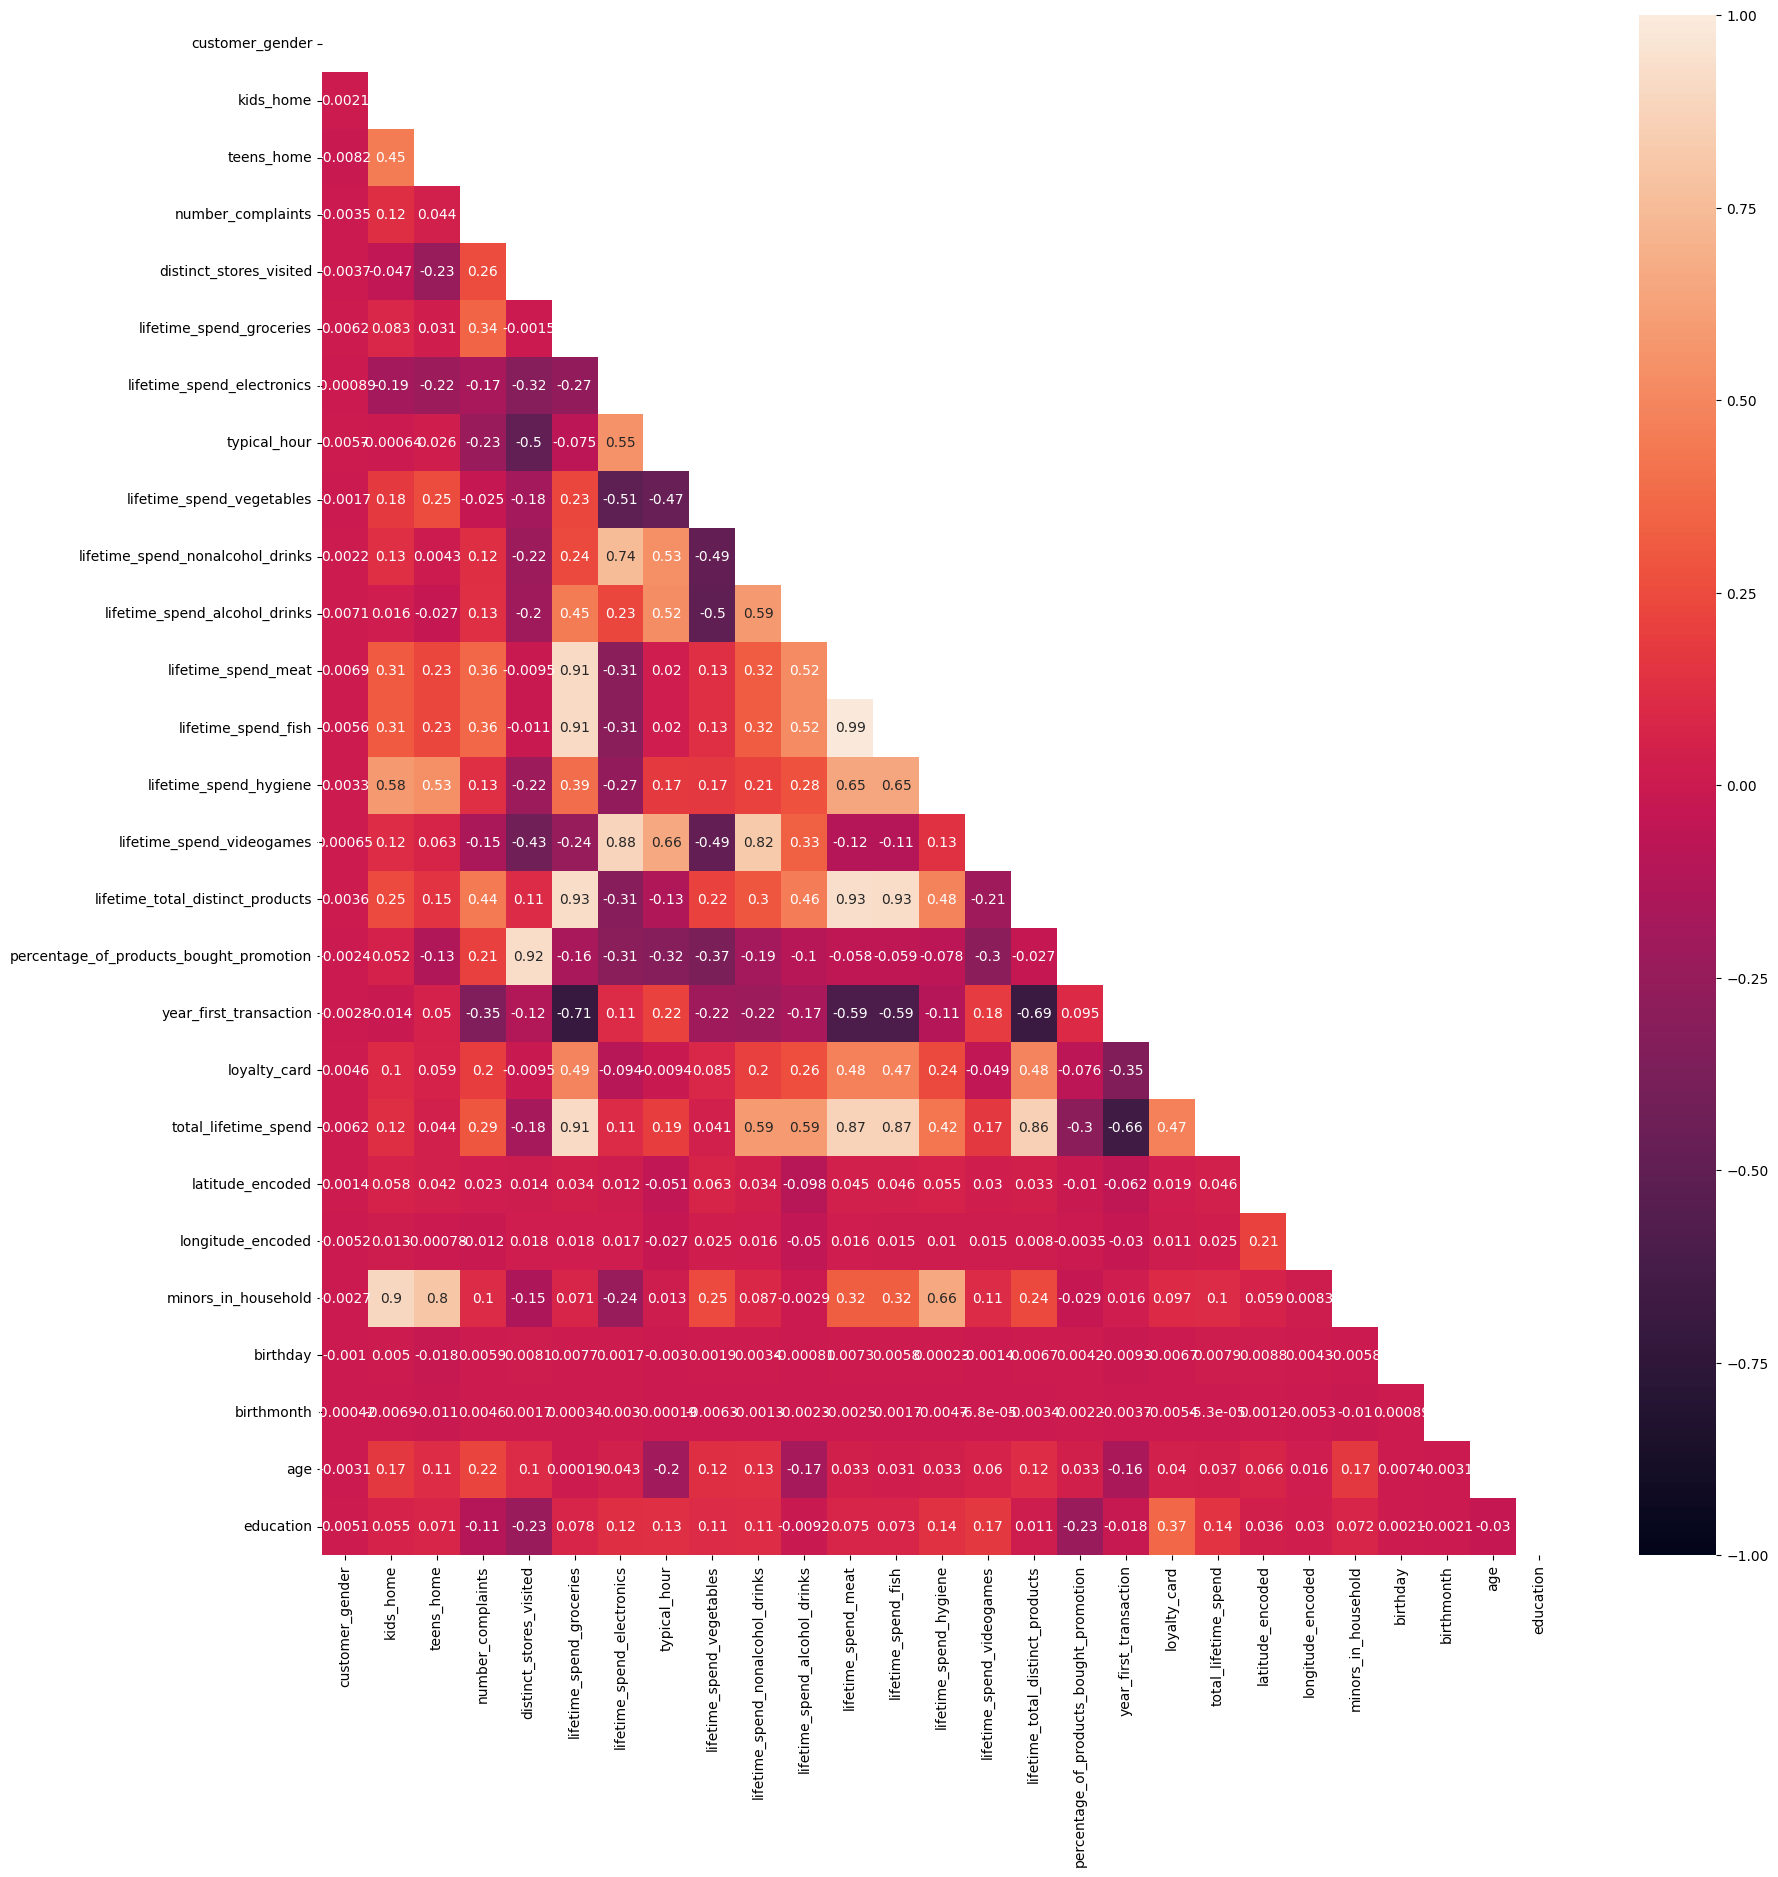

In [48]:
# Set the figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Create the correlation matrix and plot the heatmap
corr_matrix = individuals.corr()

mask = np.tri(*corr_matrix.shape, k=-1, dtype=bool)
corr_matrix.where(mask, np.NaN, inplace=True)

sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        annot=True,
        annot_kws={"fontsize": 10},
        vmin=-1, vmax=1,
        ax=ax)

plt.show()

In [53]:
Functions.get_high_correlations(corr_matrix, 0.66)

,Variable 1,Variable 2,Correlation
3,lifetime_spend_fish,lifetime_spend_meat,0.986010
8,lifetime_total_distinct_products,lifetime_spend_meat,0.929894
9,lifetime_total_distinct_products,lifetime_spend_fish,0.929424
7,lifetime_total_distinct_products,lifetime_spend_groceries,0.926119
10,percentage_of_products_bought_promotion,distinct_stores_visited,0.923021
13,total_lifetime_spend,lifetime_spend_groceries,0.913175
1,lifetime_spend_meat,lifetime_spend_groceries,0.912783
2,lifetime_spend_fish,lifetime_spend_groceries,0.912134
17,minors_in_household,kids_home,0.895671
4,lifetime_spend_videogames,lifetime_spend_electronics,0.877892


#### 5. K-Means

**Scalling**

In [34]:
individuals2 = individuals.drop(['customer_name', 'address2'], axis=1)

In [35]:
scaler = StandardScaler()
# Here, we are using fit_transform, by fitting and
# immediately transforming the data into the scaled values
scaled_data = scaler.fit_transform(individuals2)

In [37]:
scaled_data = pd.DataFrame(scaled_data, index= individuals2.index, columns=individuals2.columns)

In [38]:
scaled_data

,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,year_first_transaction,loyalty_card,total_lifetime_spend,latitude_encoded,longitude_encoded,minors_in_household,birthday,birthmonth,age,education
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,1.006875,-0.935778,-0.564934,-0.920341,-0.637922,-0.740728,-0.541249,1.368256,-1.135810,-0.885517,...,1.664114,-0.491968,-1.014165,0.256596,0.321734,-0.909998,-0.654131,0.725149,-1.596468,-0.700326
19330,-0.993172,-0.125864,-0.564934,-0.920341,-0.637922,-0.720687,2.832759,1.186763,-1.139967,1.618537,...,1.264383,-0.491968,0.287018,0.927508,-0.236817,-0.365816,1.161938,-0.145123,-0.590633,-0.700326
2272,1.006875,-0.125864,0.528148,-0.920341,2.122558,-0.682874,-0.541249,-0.991152,-0.537222,-0.513947,...,-0.134678,-0.491968,-0.982963,3.228680,1.720931,0.178366,1.729460,-1.595577,-0.925911,2.036212
25288,1.006875,1.493964,3.807393,0.274645,-0.637922,0.240717,-0.417948,-0.446674,-0.144398,0.483635,...,0.265053,-0.491968,0.433427,-0.436425,0.211704,2.899276,0.140399,-0.145123,1.588675,-0.700326
12829,1.006875,-0.935778,-0.564934,-0.920341,-0.637922,-0.742430,-0.540112,1.186763,-1.162830,-0.931963,...,1.264383,-0.491968,-1.040416,0.256596,0.321734,-0.909998,1.729460,-1.595577,-1.652347,-0.700326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,1.006875,-0.935778,-0.564934,0.274645,-0.637922,-0.718418,2.557747,1.005270,-1.144124,1.618537,...,-0.134678,2.032653,0.213663,-0.710452,-0.342572,-0.909998,-1.675670,1.305330,-0.199475,2.036212
26447,-0.993172,-0.935778,-0.564934,-0.920341,-0.484562,-0.722956,0.053095,0.097805,-0.626594,-0.721945,...,1.064517,-0.491968,-0.883506,1.081560,1.194305,-0.909998,0.594417,-1.305486,-0.870032,-0.700326
182,-0.993172,-0.935778,-0.564934,-0.920341,-0.637922,-0.742240,-0.539544,1.549749,-1.133732,-0.897633,...,1.464248,2.032653,-1.022265,-0.710452,-0.342572,-0.909998,-0.200114,-1.595577,-1.708227,-0.700326


c:\Users\carolinashaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carolinashaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carolinashaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carolinashaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

ValueError: x and y must have same first dimension, but have shapes (24,) and (48,)

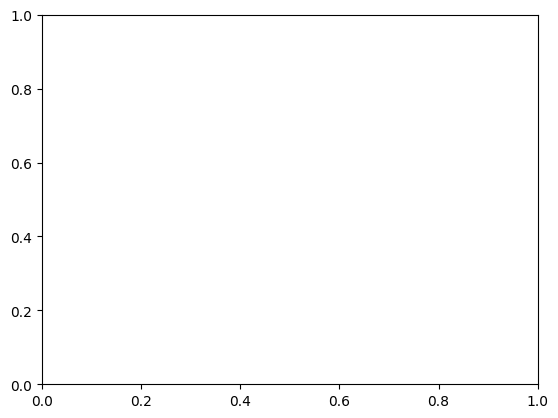

In [55]:
inertia_kmeans = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    inertia_kmeans.append(kmeans.inertia_)


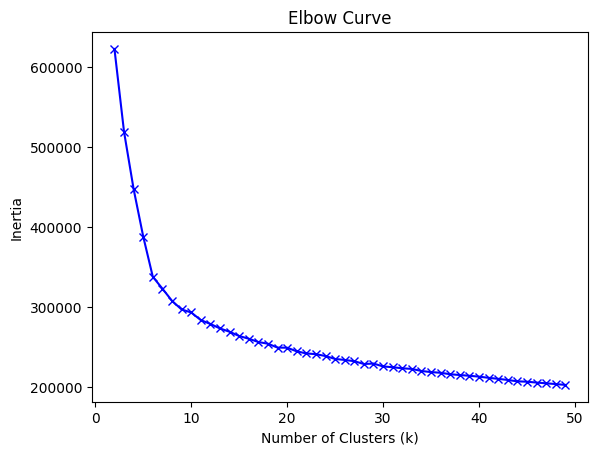

In [56]:
plt.plot(range(2, 50), inertia_kmeans, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [57]:
kmeans_solution = KMeans(n_clusters=10, random_state=0).fit(scaled_data)

c:\Users\carolinashaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
individuals['cluster_kmeans'] =  kmeans_solution.predict(scaled_data)

In [59]:
individuals

,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,...,total_lifetime_spend,address2,latitude_encoded,longitude_encoded,minors_in_household,birthday,birthmonth,age,education,cluster_kmeans
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1,0,0,0,2,91.0,20.0,22,22.0,...,1545.0,Alvalade,38.753506,-9.150181,0,10,9,24,0,8
19330,Donald Robertson,0,1,0,0,2,197.0,5958.0,21,20.0,...,10219.0,Lumiar,38.768765,-9.163855,1,26,6,42,0,3
2272,Felicia Bradshaw,1,1,1,0,20,397.0,20.0,9,310.0,...,1753.0,Loures,38.821100,-9.115927,2,31,1,36,3,1
25288,Emma Williams,1,3,4,1,2,5282.0,237.0,12,499.0,...,11195.0,Avenidas Novas,38.737745,-9.152875,7,17,6,81,0,5
12829,Hilda Huerta,1,0,0,0,2,82.0,22.0,21,9.0,...,1370.0,Alvalade,38.753506,-9.150181,0,31,1,23,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Karen Watts,1,0,0,1,2,209.0,5474.0,20,18.0,...,9730.0,Campolide,38.731513,-9.166444,0,1,11,49,3,3
26447,Curtis Thompson,0,0,0,0,3,185.0,1066.0,15,267.0,...,2416.0,Olivais,38.772268,-9.128820,0,21,2,37,0,2
182,Richard Carter,0,0,0,0,2,83.0,23.0,23,23.0,...,1491.0,Campolide,38.731513,-9.166444,0,14,1,22,0,8


In [60]:
individuals.groupby('cluster_kmeans').describe()

customer_gender                                               \
                         count      mean       std  min  25%  50%  75%  max   
cluster_kmeans                                                                
0                       4764.0  0.499790  0.500052  0.0  0.0  0.0  1.0  1.0   
1                       2316.0  0.481434  0.499763  0.0  0.0  0.0  1.0  1.0   
2                       2532.0  0.495656  0.500080  0.0  0.0  0.0  1.0  1.0   
3                       4610.0  0.494143  0.500020  0.0  0.0  0.0  1.0  1.0   
4                       4723.0  0.490366  0.499960  0.0  0.0  0.0  1.0  1.0   
5                       1740.0  0.489080  0.500024  0.0  0.0  0.0  1.0  1.0   
6                       2910.0  0.507216  0.500034  0.0  0.0  1.0  1.0  1.0   
7                       2605.0  0.500576  0.500096  0.0  0.0  1.0  1.0  1.0   
8                       1250.0  0.499200  0.500199  0.0  0.0  0.0  1.0  1.0   
9                       2324.0  0.509897  0.500010  0.0  0.0  1.0  1.0  1.0   

               kids_home            ...   age       education            \
                   count      mean  ...   75%   max     count      mean   
cluster_kmeans                      ...                                   
0                 4764.0  0.997901  ...  70.0  83.0    4764.0  0.701511   
1                 2316.0  0.999568  ...  70.0  83.0    2316.0  0.200345   
2                 2532.0  0.510269  ...  70.0  83.0    2532.0  0.312006   
3                 4610.0  0.689588  ...  70.0  83.0    4610.0  1.008894   
4                 4723.0  1.160491  ...  70.0  83.0    4723.0  1.008046   
5                 1740.0  4.598851  ...  71.0  83.0    1740.0  1.047701   
6                 2910.0  2.187285  ...  69.0  83.0    2910.0  0.959450   
7                 2605.0  1.000768  ...  69.0  83.0    2605.0  0.196929   
8                 1250.0  0.016000  ...  24.0  33.0    1250.0  0.000000   
9                 2324.0  0.166093  ...  31.0  64.0    2324.0  1.601979   

                                                   
                     std  min  25%  50%  75%  max  
cluster_kmeans                                     
0               1.067878  0.0  0.0  0.0  1.0  3.0  
1               0.650980  0.0  0.0  0.0  0.0  3.0  
2               0.773299  0.0  0.0  0.0  0.0  3.0  
3               1.163247  0.0  0.0  0.5  2.0  3.0  
4               1.162350  0.0  0.0  1.0  2.0  3.0  
5               1.166684  0.0  0.0  1.0  2.0  3.0  
6               1.141910  0.0  0.0  0.0  2.0  3.0  
7               0.649345  0.0  0.0  0.0  0.0  3.0  
8               0.000000  0.0  0.0  0.0  0.0  0.0  
9               1.078661  0.0  1.0  2.0  3.0  3.0  

[10 rows x 216 columns]